In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))


TensorFlow Version: 2.3.0


In [2]:
tf.__version__
tf.keras.__version__

'2.4.0'

In [3]:
# library
import pandas as pd
import os 
import feather
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import logsumexp
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import re
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
from tensorflow.keras import callbacks
from tensorflow import keras
from utils import *

In [4]:
# read in 
WU = feather.read_dataframe('Data/WU.feather')

#pp
WU = WU.drop(columns=['Index','year','ParcelID','Days','year','month'])


p_scalar = preprocessing.StandardScaler()
predictors = ['TotalWaterUse','ET_turf_month_mean']
p_scalar.fit(WU.loc[:,predictors])
WU.loc[:,predictors] = p_scalar.transform(WU.loc[:,predictors])

nlag = 7
nlead = 12 # num of forecasting steps
WU_lag = add_group_leadlags(data=WU, group='E_Label_ParcelID', timeindex='monthIndex',
                        lag_features = ['TotalWaterUse','ET_turf_month_mean'],
                        lead_features = ['TotalWaterUse'],
                        other = ['Set'],
                        nlag=nlag, nlead=nlead,
                        fillna=None)

# shouldt have test set of only one month!
WU_lag_dropna = WU_lag.dropna()

# dev is special here
WU_lag_dev = add_group_leadlags(data=WU[WU.loc[:,'Set']!='test'], group='E_Label_ParcelID', timeindex='monthIndex',
                        lag_features = ['TotalWaterUse','ET_turf_month_mean'],
                        lead_features = ['TotalWaterUse'],
                        other = ['Set'],
                        nlag=nlag, nlead=nlead,
                        fillna=None).dropna()

WU_final = pd.concat([WU_lag_dev,WU_lag_dropna[WU_lag_dropna.loc[:,'Set'] == 'test']],axis=0 )

# Tensor generation

In [5]:
def lstmtensor_longterm_forecast(data,feature_patterns,target_pattern, sets): 
    
    # whole predictive tensor: out
    for i,p in enumerate(feature_patterns):
    
        X = data.filter(like=p,axis=1).values
        xshape = X.shape
        # add axis 2
        Xre = X.reshape(xshape[0],xshape[1],1)
    
        if(i == 0):
            out = Xre
        else:
            # concat on feature dimension
            out = np.concatenate([out,Xre],axis=2)
    
    # whole target: outy 
    y_lag = data.filter(like=target_pattern+'_lag',axis=1).values[:,::-1]
    y_lead = data.filter(like=target_pattern+'_lead',axis=1).values
    nlags = y_lag.shape[1]
    nleads = y_lead.shape[1]
    y = np.concatenate([y_lag,y_lead],axis=1)
 
    # reshape y along feature axis (not time!) 
    for t in np.arange(1,nlag+1):
        
        Yhere = y[:,t:(t+nleads)]
        Yhere2 = Yhere.reshape([-1,1,nleads])
        
        if(t == 1):
            outy = Yhere2
        else:
            outy = np.concatenate([outy,Yhere2],axis=1)
    
    
    # split tensor into dict: outdict, outydict
    setnames = data.loc[:,sets].unique()
    outdict = {}
    outydict = {}
    for s in setnames:
        Xs = out[(data.loc[:,sets] == s),:,:][:,::-1,:] # reverse
        ys = outy[(data.loc[:,sets] == s),:,:]
        #print(Xs.shape)
        Xdict = {s: Xs}
        outdict.update(Xdict)
        ydict = {s:ys}
        outydict.update(ydict)
    
    return outdict, outydict

In [6]:
predictors = ['TotalWaterUse_lag','ET_turf_month_mean_lag']
Xdict, ydict = lstmtensor_longterm_forecast(data=WU_final,
                          feature_patterns= predictors,
                          target_pattern='TotalWaterUse',
                          sets='Set')

In [7]:
# find batch size 
# can skip this chunck and directly define a batch size
bs_remain_list = []
bs_list=[]
for bs in np.arange(16, 500):
    r_train = Xdict['train'].shape[0]%bs
    r_dev = Xdict['dev'].shape[0]%bs
    bs_remain_list.append(r_train+r_dev)
    bs_list.append(bs)
    
batch_size = pd.Series(bs_remain_list,index=bs_list).idxmin()

# or find remain train sample size
batch_size=32
r_train = Xdict['train'].shape[0]%batch_size
# batch size for val and test is just for speed concern
r_dev = Xdict['dev'].shape[0]%batch_size 
r_test = Xdict['test'].shape[0]%batch_size

s=Xdict['train'].shape[0]//batch_size

In [8]:
def buildmodel(n_hidden = 1, dense_dp = 0, recurrent_dp= 0 ,l2=0.001, training = None):
    
    Input_ = keras.layers.Input(shape = Xdict['train'].shape[1:])
    
    Z = Input_
    for _ in range(n_hidden):
        Z = GRU(32, input_shape = (nlag,len(predictors)),
                  recurrent_dropout = recurrent_dp,
                  dropout = dense_dp,
                  kernel_regularizer=keras.regularizers.l2(l2),
                  return_sequences = True)(Z,training = training)

    Z = TimeDistributed(Dense(32, kernel_regularizer=keras.regularizers.l2(l2),
                              activation = 'elu',kernel_initializer='he_normal'))(Z)
    Z = Dropout(rate=dense_dp)(Z,training = training)
    Z = TimeDistributed(Dense(32, kernel_regularizer=keras.regularizers.l2(l2),
                              activation = 'elu',kernel_initializer='he_normal'))(Z)
    Z = Dropout(rate=dense_dp)(Z,training = training)
    Output_ = Dense(nlead)(Z)
    
    model = keras.Model(inputs=[Input_],outputs=[Output_])
    return model

# dev

In [9]:
dp_rate=0.1
r_dp = 0
l2=0.00001
n_hidden =1
lr=1e-5


del model
tf.keras.backend.clear_session()

In [10]:
# seq API
model = buildmodel(n_hidden = n_hidden ,dense_dp = dp_rate, recurrent_dp=r_dp,l2=l2)

In [11]:
@tf.function
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(tf.reshape(Y_true[:,-1,:],[-1]),tf.reshape( Y_pred[:,-1,:],[-1]) )

In [12]:
model.compile(optimizer = Adam(learning_rate=lr), loss = 'mean_squared_error',metrics = [last_time_step_mse] )
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 2)]            0         
_________________________________________________________________
gru (GRU)                    (None, 7, 32)             3456      
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 32)             1056      
_________________________________________________________________
dropout (Dropout)            (None, 7, 32)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 32)             1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 7, 12)            

In [13]:
callback_list =[
    callbacks.EarlyStopping(
        monitor = 'val_last_time_step_mse',
        restore_best_weights=True,
        patience= 10
    ),
    callbacks.ModelCheckpoint(
        filepath='LSTM_log/lstm_dev_final_12m.h5',
        save_best_only= True,
        monitor= 'val_last_time_step_mse'
    ),
    #callbacks.ReduceLROnPlateau(factor=0.5,patience=5), # eta performance scheduling
    callbacks.TensorBoard(log_dir='LSTM_log',histogram_freq=1)
]

In [14]:
# seed
tf.random.set_seed(1)
np.random.seed(1)

In [15]:
# seq api
target_axis = 0
history = model.fit(x= Xdict['train'][r_train:,:,:],
                    y= ydict['train'][r_train:,:,:], # shift one time point
                    epochs= 100,
                    batch_size= batch_size,
                    validation_data=( Xdict['dev'],ydict['dev']),
                    callbacks=callback_list)


Epoch 1/100
  1/331 [..............................] - ETA: 0s - loss: 1.1257 - last_time_step_mse: 1.0967WARNING:tensorflow:From C:\Users\Yi\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
331/331 [==============================] - 2s 6ms/step - loss: 0.9932 - last_time_step_mse: 0.9830 - val_loss: 0.8882 - val_last_time_step_mse: 0.8318
Epoch 2/100
331/331 [==============================] - 1s 4ms/step - loss: 0.9187 - last_time_step_mse: 0.9003 - val_loss: 0.8203 - val_last_time_step_mse: 0.7648
Epoch 3/100
331/331 [==============================] - 1s 4ms/step - loss: 0.8562 - last_time_step_mse: 0.8281 - val_loss: 0.7617 - val_last_time_step_mse: 0.7100
Epoch 4/100
331/331 [==============================] - 2s 5ms/step - loss: 0.8036 - last_time_step_mse: 0.7721 - val_loss: 0.7114 - val_la

Epoch 48/100
331/331 [==============================] - 1s 4ms/step - loss: 0.5719 - last_time_step_mse: 0.5639 - val_loss: 0.5060 - val_last_time_step_mse: 0.5563
Epoch 49/100
331/331 [==============================] - 1s 4ms/step - loss: 0.5719 - last_time_step_mse: 0.5671 - val_loss: 0.5058 - val_last_time_step_mse: 0.5560
Epoch 50/100
331/331 [==============================] - 1s 3ms/step - loss: 0.5728 - last_time_step_mse: 0.5654 - val_loss: 0.5058 - val_last_time_step_mse: 0.5563
Epoch 51/100
331/331 [==============================] - 1s 3ms/step - loss: 0.5721 - last_time_step_mse: 0.5626 - val_loss: 0.5057 - val_last_time_step_mse: 0.5561
Epoch 52/100
331/331 [==============================] - 1s 4ms/step - loss: 0.5710 - last_time_step_mse: 0.5596 - val_loss: 0.5057 - val_last_time_step_mse: 0.5566
Epoch 53/100
331/331 [==============================] - 1s 4ms/step - loss: 0.5699 - last_time_step_mse: 0.5672 - val_loss: 0.5056 - val_last_time_step_mse: 0.5568
Epoch 54/100
331

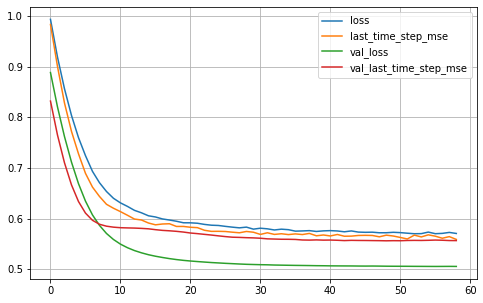

In [16]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)

plt.show()

In [17]:
pred = model.predict(Xdict['dev'])[:,-1,:].flatten()
true = ydict['dev'][:,-1,:].flatten()

ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]

y_hat = pred*np.sqrt(yvar)+ymean
y_true = true*np.sqrt(yvar)+ymean

In [18]:
stop_epoch = pd.Series(history.history['val_last_time_step_mse'],index = history.epoch).idxmin()

# Tune tau

In [19]:
@tf.function
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(tf.reshape(Y_true[:,-1,:],[-1]),tf.reshape( Y_pred[:,-1,:],[-1]) )

In [20]:
T= 1000
tf.random.set_seed(1)
np.random.seed(1)

class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

    
mc_model = Sequential([
    MCDropout(dp_rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])

mc_model.compile(optimizer = Adam(), loss = 'mean_squared_error',metrics = ['mean_squared_error'] )
mc_model.set_weights(model.get_weights())
tf.random.set_seed(1)
np.random.seed(1)

# mc dp
X_test_tf = tf.constant(Xdict['dev'], dtype=tf.float32 )
y_probas = np.stack([mc_model.predict(X_test_tf,batch_size=batch_size*100)[:,-1,:].flatten() # 973 x 12 = whole test
                     for sample in range(T)])
print('done')
print(y_probas.shape)

done
(1000, 1200)


In [21]:
target_axis = 0
ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]

y_hat_MC = y_probas * np.sqrt(yvar)+ymean
y_hat = y_hat_MC.mean(axis=0)
sig_hat = y_hat_MC.std(axis=0)

true = ydict['dev'][:,-1,:].flatten()
y_true = true*np.sqrt(yvar)+ymean

In [22]:
grid_ll = []
taul, tl = [], []
for t in range(100):
    tau = 2**(-t)
    ll = (logsumexp(-0.5 * tau * (y_true - y_hat_MC)**2., 0) - np.log(T) - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(ll)
    taul.append(tau)
    grid_ll.append(test_ll)
    tl.append(t)
    
    

best_t = tl[grid_ll.index(max(grid_ll))]
best_tau = taul[grid_ll.index(max(grid_ll))]

G = 100
gg = (taul[grid_ll.index(max(grid_ll))-1] - taul[grid_ll.index(max(grid_ll))+1])/G
grid_ll = []
taul, tl = [], []
for t in range(G):
    tau = 2**(-best_t-1) +  gg*t
    ll = (logsumexp(-0.5 * tau * (y_true - y_hat_MC)**2., 0) - np.log(T) - 0.5*np.log(2*np.pi) + 0.5*np.log(tau))
    test_ll = np.mean(ll)
    taul.append(tau)
    grid_ll.append(test_ll)
    tl.append(t)
    

In [25]:
rmse = round(np.sqrt(mean_squared_error(y_true,y_hat)),4) 

best_t = tl[grid_ll.index(max(grid_ll))]
best_tau = taul[grid_ll.index(max(grid_ll))]
print('final tune value: tau:{} t:{} LL:{} RMSE:{}'.format(best_tau, best_t, max(grid_ll),rmse ))

final tune value: tau:2.0503997802734375e-07 t:24 LL:-9.1351814526125 RMSE:2246.396


In [26]:
# model sig
sig = np.sqrt(1/best_tau) 

In [27]:
# hyper-par: tau
np.random.seed(1)
y_MC_mixture = np.concatenate([np.random.normal(loc=samplei,scale=sig,size=(10,len(samplei))) for samplei in y_hat_MC] , axis=0)

In [49]:
alpha= 0.05
L_hat = np.quantile(y_MC_mixture,alpha/2,axis=0)
U_hat = np.quantile(y_MC_mixture,(1-alpha/2),axis=0)

left = L_hat
right = U_hat
py_all = np.stack([norm.pdf(y_true, loc=samplei, scale=sig) for samplei in y_hat_MC])
p_y = py_all.mean(axis=0)
sig_hat2 = y_MC_mixture.std(axis=0)

# save to MF

In [29]:
WU2 = feather.read_dataframe('Data/WU.feather')
WU2[WU2.loc[:,'Set']=='dev'].loc[:,'Index'].values


all_dev_MF = pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='dev'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'L': left,
    'U': right,
    'sig_hat': sig_hat2,
    'p_y':p_y
})

path = 'Out_dev_MF\\month12\\LSTM_MC_dev_12m_dist.feather'
feather.write_dataframe(all_dev_MF, path)

In [30]:

del model
tf.keras.backend.clear_session()

# Test

In [31]:
model = buildmodel(n_hidden = n_hidden, dense_dp = dp_rate, recurrent_dp=r_dp,l2=l2)

model.compile(optimizer = Adam(learning_rate=lr), loss = 'mean_squared_error',metrics = [last_time_step_mse] )

In [32]:
from tensorflow.keras import utils
#utils.plot_model(model) #keras bug

predictors = ['TotalWaterUse_lag','ET_turf_month_mean_lag']
Xdict2, ydict2 = lstmtensor_longterm_forecast(data=WU_lag.dropna(),
                          feature_patterns= predictors,
                          target_pattern='TotalWaterUse',
                          sets='Set')

callback_list =[
    callbacks.EarlyStopping(
        monitor = 'val_mean_squared_error',
        patience= stop_epoch
    ),
    callbacks.ModelCheckpoint(
        filepath='LSTM_log/lstm_final_12m.h5',
        #save_best_only= True,
        monitor='val_mean_squared_error'
    ),
    callbacks.TensorBoard(log_dir='LSTM_log')
]

train_all = np.concatenate([Xdict2['train'],Xdict2['dev']], axis= 0)
train_all_y = np.concatenate([ydict2['train'],ydict2['dev']], axis= 0)

batch_size=32
r_train = train_all.shape[0]%batch_size
r_train

24

In [33]:
# seed
tf.random.set_seed(1)
np.random.seed(1)

target_axis = 0
history = model.fit(x= train_all[r_train:,:,:],
                    y= train_all_y[r_train:,:,:], # shift one time point
                    epochs= stop_epoch,
                    batch_size= batch_size,
                    validation_data=( Xdict2['test'],ydict2['test']),
                    callbacks=callback_list)


Epoch 1/48
368/368 [==============================] - 3s 9ms/step - loss: 0.9124 - last_time_step_mse: 0.9028 - val_loss: 0.8810 - val_last_time_step_mse: 0.7640
Epoch 2/48
368/368 [==============================] - 1s 4ms/step - loss: 0.8407 - last_time_step_mse: 0.8210 - val_loss: 0.8141 - val_last_time_step_mse: 0.6944
Epoch 3/48
368/368 [==============================] - 2s 4ms/step - loss: 0.7828 - last_time_step_mse: 0.7575 - val_loss: 0.7587 - val_last_time_step_mse: 0.6398
Epoch 4/48
368/368 [==============================] - 1s 4ms/step - loss: 0.7359 - last_time_step_mse: 0.7047 - val_loss: 0.7138 - val_last_time_step_mse: 0.5981
Epoch 5/48
368/368 [==============================] - 1s 4ms/step - loss: 0.6986 - last_time_step_mse: 0.6681 - val_loss: 0.6791 - val_last_time_step_mse: 0.5687
Epoch 6/48
368/368 [==============================] - 1s 3ms/step - loss: 0.6665 - last_time_step_mse: 0.6392 - val_loss: 0.6535 - val_last_time_step_mse: 0.5504
Epoch 7/48
368/368 [========

Epoch 19/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5913 - last_time_step_mse: 0.5838 - val_loss: 0.5876 - val_last_time_step_mse: 0.5203
Epoch 20/48
368/368 [==============================] - 2s 4ms/step - loss: 0.5913 - last_time_step_mse: 0.5798 - val_loss: 0.5863 - val_last_time_step_mse: 0.5192
Epoch 21/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5901 - last_time_step_mse: 0.5857 - val_loss: 0.5851 - val_last_time_step_mse: 0.5187
Epoch 22/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5881 - last_time_step_mse: 0.5818 - val_loss: 0.5839 - val_last_time_step_mse: 0.5165
Epoch 23/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5866 - last_time_step_mse: 0.5811 - val_loss: 0.5829 - val_last_time_step_mse: 0.5158
Epoch 24/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5864 - last_time_step_mse: 0.5777 - val_loss: 0.5820 - val_last_time_step_mse: 0.5157
Epoch 25/48
368/368 [=

368/368 [==============================] - 1s 4ms/step - loss: 0.5804 - last_time_step_mse: 0.5712 - val_loss: 0.5758 - val_last_time_step_mse: 0.5098
Epoch 38/48
368/368 [==============================] - 1s 3ms/step - loss: 0.5778 - last_time_step_mse: 0.5726 - val_loss: 0.5757 - val_last_time_step_mse: 0.5099
Epoch 39/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5779 - last_time_step_mse: 0.5704 - val_loss: 0.5754 - val_last_time_step_mse: 0.5098
Epoch 40/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5762 - last_time_step_mse: 0.5709 - val_loss: 0.5752 - val_last_time_step_mse: 0.5095
Epoch 41/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5775 - last_time_step_mse: 0.5748 - val_loss: 0.5750 - val_last_time_step_mse: 0.5091
Epoch 42/48
368/368 [==============================] - 1s 4ms/step - loss: 0.5749 - last_time_step_mse: 0.5717 - val_loss: 0.5749 - val_last_time_step_mse: 0.5096
Epoch 43/48
368/368 [=============

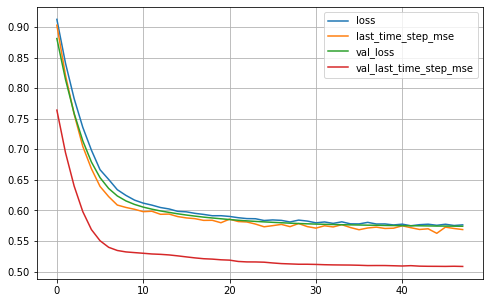

In [34]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [35]:
pred = model.predict(Xdict2['test'])[:,-1,:].flatten()
true = ydict2['test'][:,-1,:].flatten()

ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]
y_hat = pred*np.sqrt(yvar)+ymean
y_true = true*np.sqrt(yvar)+ymean

In [36]:
predictors = ['TotalWaterUse_lag','ET_turf_month_mean_lag']
Xdict2, ydict2 = lstmtensor_longterm_forecast(data=WU_lag.dropna(),
                          feature_patterns= predictors,
                          target_pattern='TotalWaterUse',
                          sets='Set')

In [37]:
train_all = np.concatenate([Xdict2['train'],Xdict2['dev']], axis= 0)
train_all_y = np.concatenate([ydict2['train'],ydict2['dev']], axis= 0)

pred = model.predict(Xdict2['test'])[:,-1,:].flatten()
true = ydict2['test'][:,-1,:].flatten()

target_axis = 0
ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]
y_hat = pred*np.sqrt(yvar)+ymean
y_true = true*np.sqrt(yvar)+ymean

In [38]:
T= 1000

tf.random.set_seed(1)
np.random.seed(1)

class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

    
mc_model = Sequential([
    MCDropout(dp_rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])

mc_model.compile(optimizer = Adam(), loss = 'mean_squared_error',metrics = ['mean_squared_error'] )
mc_model.set_weights(model.get_weights())
tf.random.set_seed(1)
np.random.seed(1)

# mc dp
X_test_tf = tf.constant(Xdict2['test'], dtype=tf.float32 )
y_probas = np.stack([mc_model.predict(X_test_tf,batch_size=batch_size*100)[:,-1,:].flatten() # 973 x 12 = whole test
                     for sample in range(T)])
print('done')
print(y_probas.shape)

done
(1000, 1200)


In [50]:
target_axis = 0
ymean = p_scalar.mean_[target_axis]
yvar = p_scalar.var_[target_axis]
y_hat_MC = y_probas * np.sqrt(yvar)+ymean
y_hat = y_hat_MC.mean(axis=0)
sig_hat = y_hat_MC.std(axis=0)

In [51]:
# hyper-par: tau
np.random.seed(1)
y_MC_mixture = np.concatenate([np.random.normal(loc=samplei,scale=sig,size=(10,len(samplei))) for samplei in y_hat_MC] , axis=0)

In [54]:
alpha= 0.05
L_hat = np.quantile(y_MC_mixture,alpha/2,axis=0)
U_hat = np.quantile(y_MC_mixture,(1-alpha/2),axis=0)

left = L_hat
right = U_hat

py_all = np.stack([norm.pdf(y_true, loc=samplei, scale=sig) for samplei in y_hat_MC])
p_y = py_all.mean(axis=0)

# Save

In [56]:
WU2 = feather.read_dataframe('Data/WU.feather')

original_y_true =  WU2[WU2.loc[:,'Set']=='test'].loc[:,'TotalWaterUse'].values

sig_hat2 = y_MC_mixture.std(axis=0)

all_test_MF_LSTM = pd.DataFrame({
    'Index': WU2[WU2.loc[:,'Set']=='test'].loc[:,'Index'].values,
    'Y': y_true,
    'y_hat': y_hat,
    'L': left,
    'U': right,
    'sig_hat': sig_hat2,
    'p_y':p_y
})

path = 'Out_test_MF\\month12\\LSTM_MC_12m_dist.feather'
feather.write_dataframe(all_test_MF_LSTM , path)

In [57]:
# write sample for ECPI
path = 'Out_test_MF\\month12\\LSTM_MC.npy'
np.save(path, y_MC_mixture)

# report

In [60]:
r1,r2,r3,r4,r5 = get_RMSE_NLL_NOIS_AWPI_ECPI(y_true,y_hat,left,right,alpha=0.05)

 & 2292.05 & 9.15 & 12711.62 & 8795.85 & 0.93 & 95\% \\


In [61]:
# results
with open("Results/Results_12m.txt", "a") as myfile:
    myfile.write("LSTM \n")
    myfile.write('RMSE %f & NLL %f & NOIS %f & AWPI %f & ECPI %f \n' % (
        r1,-np.log(p_y).mean(),r3,r4,r5 ))